We consider the Hamiltonian,
\begin{equation}
H_0 = \sum_{ij} \hat{\sigma}^x_i \hat{\sigma}^x_j + h \sum_i \hat{\sigma}^z_i
\end{equation}

And we invoke,
\begin{align*}
\mathcal{H} =& H_{-} + H_{+}\\
H_{+} =& H_0 + \Gamma  \sum_i \hat{\sigma}^x_i\\
H_{-} =& H_0 - \Gamma  \sum_i \hat{\sigma}^x_i
\end{align*}

Regarding the unitary operator,

\begin{align*}
U_F =& e^{-i \frac{\pi}{2}\sum_i \hat{\sigma}^z_i}U_{-} U_{+}
\end{align*}

Is U unitary? True


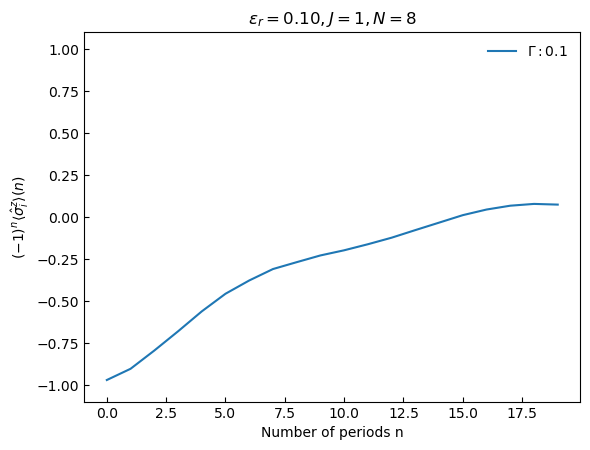

In [65]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

def hamiltonians(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    Jvalue = args['J']
    beta = args['beta']
    gamma = args['gamma']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
    '''    
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
    '''
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H1 = H1 + Qobj(tensor(id, tensor(sx, tensor(id1, tensor(sx,id2)))).full())\
            * j_ij(Jvalue, i,j, beta)

    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sx,id1)).full())

    H0 = H1/N + Qobj(h * H2.full())
    H1 = gamma * H3

    return H0, H1, H2, H3

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H0, H1, H2, H3 = hamiltonians(args)
    H_p = (H0 + H1).full()
    H_m = (H0 - H1).full() 
    H_pi = (np.pi/2 * H3).full()
    
    U_p = expm(-1j * H_p)
    U_n = expm(-1j * H_m)
    U_pi = expm(-1j *  H_pi)
    
    U  = U_pi @ U_p
    #U  = U_p
    expValues = []
    psi = basis(2**N, 0).full()
    #psi = np.ones(2**N)/np.sqrt(N)
    
    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, (H2/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues
    

N = 8
nn = 20  # Time period upto which stroboscopic evolution is computed
J = 1
h = 1
gammas = [0.1]

beta = float('inf')
#beta = 0

params = [{'er':er, 'N':N,'J':J, 'g':g, 'maxT':nn,\
           'h':h, 'nn':nn, 'beta':beta, 'gamma':gamma} for gamma in gammas]

nprocs = len(gammas)
p = Pool(processes = nprocs) 
opts = Options(num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, h in enumerate(gammas):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$\Gamma:{h}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
#for i in np.arange(0, nn, 2):
#    plt.axvline(x = i, color = 'blue', alpha = 0.3,ls ='--')


plt.xlabel('Number of periods n')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\epsilon_r={er:1.2f}, J={J},  N={N}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')

plt.ylim(-1.1, 1.1)

plt.legend(frameon =False)
plt.show()